# Imports

In [1]:
import numpy as np
from scipy.fftpack import fft
from qiskit_aer import AerSimulator
from matplotlib import pyplot as plt
from qiskit.circuit.library import QFT
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

# Constants

In [2]:
simulator = AerSimulator()              # Local quantum simulator
plt.rcParams["figure.dpi"] = 300        # Fix plot quality.
plt.rcParams["figure.figsize"] = (12,3) # Fix plot size/aspect.

# Wave Class

In [3]:
class Wave(object):
    """A class for signal representation and processing."""

    def __init__(self, rate, samples):
        """
            Set the Wave class attributes.

            Parameters:
                rate (int): The sample rate of the sound.
                samples ((n,) ndarray): NumPy array of samples.
        """
        self.rate = rate
        self.samples = samples
        self.dft = fft(self.samples)

    def plot(self):
        """
            Plot the graph of the wave (time v amplitude)
            and the Fourier transform (frequency v magnitude).
        """

        # Create a time domain over which to plot.
        time = len(self.samples) / self.rate
        domain = np.linspace(0, time, len(self.samples))

        # Use the DFT of the samples to get the frequencies and magnitudes.
        # Note, we only save the first half of the (symmetric) frequency domain.
        magnitude = np.abs(self.dft)[:self.rate//2]
        frequencies = np.arange(len(magnitude)) * self.rate / len(self.samples)

        # Plot the samples over the time domain.
        ax1 = plt.subplot(121)
        ax1.plot(domain, self.samples)
        ax1.set_xlabel("Time")
        ax1.set_ylabel("Samples")

        # Plot the magnitude over the frequency domain.
        ax2 = plt.subplot(122)
        ax2.plot(frequencies, magnitude)
        ax2.set_xlabel("Frequency")
        ax2.set_ylabel("Magnitude")

        # Title and show the plot.
        plt.suptitle("A Plot of the Wave and the Frequency Domain")
        plt.show()

    def extractFrequencies(self, n, tolerance=3):
        """
            Extract the largest n frequencies from the samples.

            Parameters:
                n (int): The number of unique frequencies to extract.
                tolerance (float): The tolerance for unique frequencies.
        """

        # Instantiate needed variables.
        i = 0
        mainFrequencies = []

        # Sort the DFT then scale the indicies to frequencies.
        sortedDft = np.argsort(self.dft[:self.rate//2])[::-1]
        sortedFreqs = np.abs((sortedDft * self.rate) / len(self.dft))


        # Run a loop to find n unique frequencies.
        while len(mainFrequencies) < n:

            # Initialize and indicator variable.
            alreadyFound = False

            # Find the next largest frequency.
            for j in range(len(mainFrequencies)):

                # Check to see if this frequency is within tolerance of another.
                if abs(sortedFreqs[i] - mainFrequencies[j]) < tolerance:
                    alreadyFound = True

            # Only add new (unique) frequencies to the list.
            if alreadyFound == False:
                mainFrequencies.append(sortedFreqs[i])
            i += 1

        # Return the list of n unique largest frequencies.
        return mainFrequencies

    def __add__(self, other):
        """
            Combine the samples from two Wave objects.

            Parameters:
                other (Wave): An object containing the samples to add
                    to the samples contained in this object.

            Returns:
                (Wave): A new Wave instance with the combined samples.

            Raises:
                ValueError: if the two sample arrays are not the same length.
        """

        # Raise a value error if the samples are not the same length.
        if len(self.samples) != len(other.samples): 
            raise ValueError("Sample arrays are not the same length.")

        # Otherwise add the two samples element-wise and return as a new Wave.
        newSamples = self.samples + other.samples
        return Wave(self.rate, newSamples)

# Functions

In [4]:
def generateWave(frequency, duration, rate=44100):
    """
        Generate an new Wave with the desired frequency and duration.

    Parameters:
        frequency (float): The frequency of the desired wave.
        duration (float): The length of the desired wave.
        rate (int): The sample rate (defaults to 44100).

    Returns:
        (Wave): An instance of the Wave class.
    """

    # Define a function with the provided frequency.
    f = lambda x: np.sin(2 * np.pi * frequency * x)

    # Apply the function to the specified number of time samples.
    samples = np.linspace(0, duration, rate*duration)
    samples = f(samples)

    # Return the samples in a Wave object.
    return Wave(rate, samples)

# Experiment

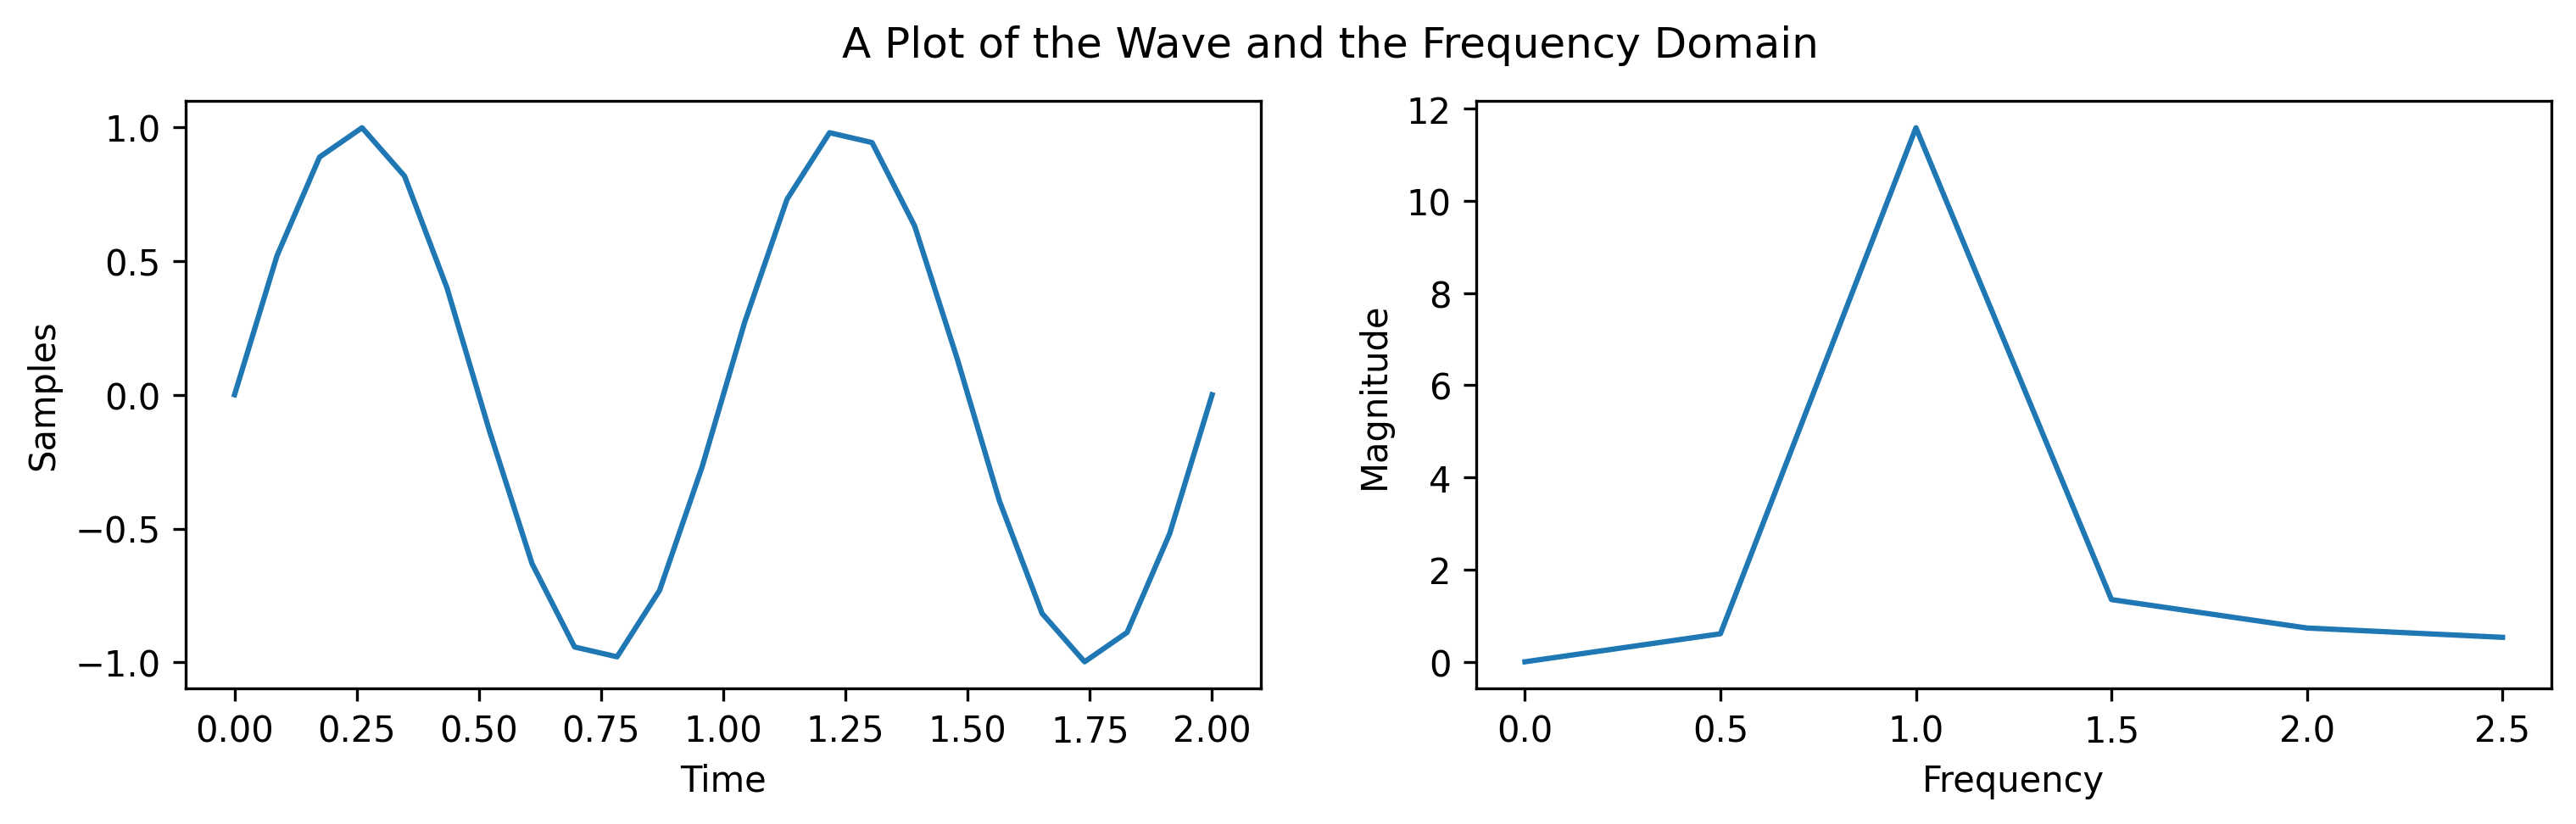

True frequency: 1
Main frequency: 1.0
Total samples:  24


In [5]:
# Define constants for a new wave.
frequency = 1
duration = 2
rate = 12

# Generate the wave, plot it, and extract the key frequency.
wave = generateWave(frequency, duration, rate)
wave.plot()
extractedFrequency = wave.extractFrequencies(1)

# Print the results.
print(f"True frequency: {frequency}")
print(f"Main frequency: {extractedFrequency[0]}")
print(f"Total samples:  {len(wave.samples)}")

In [6]:
def qft(samples, encoding, inverse, shots=4094):
    n = len(samples)
    circ = QuantumCircuit(n)
    if encoding != 'basis':
        for i in range(n):
            circ.h(i)
    for i, sample in enumerate(samples):
        if encoding == 'phase':
            circ.p(sample, i)
        elif encoding == 'rz':
            circ.rz(sample, i)
        elif encoding == 'basis':
            if sample <= -0.5:
                pass
            elif sample <= 0:
                circ.h(i)
            elif sample <= 0.5:
                circ.x(i)
            elif sample <= 1:
                circ.x(i)
                circ.h(i)
    if inverse:
        circ.compose(QFT(24, inverse=True), inplace=True)
    else:
        circ.compose(QFT(24), inplace=True)
    print(circ)
    circ.measure_all()
    
    compiledCirc = transpile(circ, simulator)
    result = simulator.run(compiledCirc, shots=shots).result()
    counts = result.get_counts(compiledCirc)
    return counts

      ┌───┐     ┌───────────┐
 q_0: ┤ H ├─────┤0          ├
      ├───┤┌───┐│           │
 q_1: ┤ X ├┤ H ├┤1          ├
      ├───┤├───┤│           │
 q_2: ┤ X ├┤ H ├┤2          ├
      ├───┤├───┤│           │
 q_3: ┤ X ├┤ H ├┤3          ├
      ├───┤├───┤│           │
 q_4: ┤ X ├┤ H ├┤4          ├
      ├───┤└───┘│           │
 q_5: ┤ X ├─────┤5          ├
      ├───┤     │           │
 q_6: ┤ H ├─────┤6          ├
      └───┘     │           │
 q_7: ──────────┤7          ├
                │           │
 q_8: ──────────┤8          ├
                │           │
 q_9: ──────────┤9          ├
                │           │
q_10: ──────────┤10         ├
      ┌───┐     │           │
q_11: ┤ H ├─────┤11         ├
      ├───┤     │   IQFT_dg │
q_12: ┤ X ├─────┤12         ├
      ├───┤┌───┐│           │
q_13: ┤ X ├┤ H ├┤13         ├
      ├───┤├───┤│           │
q_14: ┤ X ├┤ H ├┤14         ├
      ├───┤├───┤│           │
q_15: ┤ X ├┤ H ├┤15         ├
      ├───┤├───┤│           │
q_16: ┤ X 

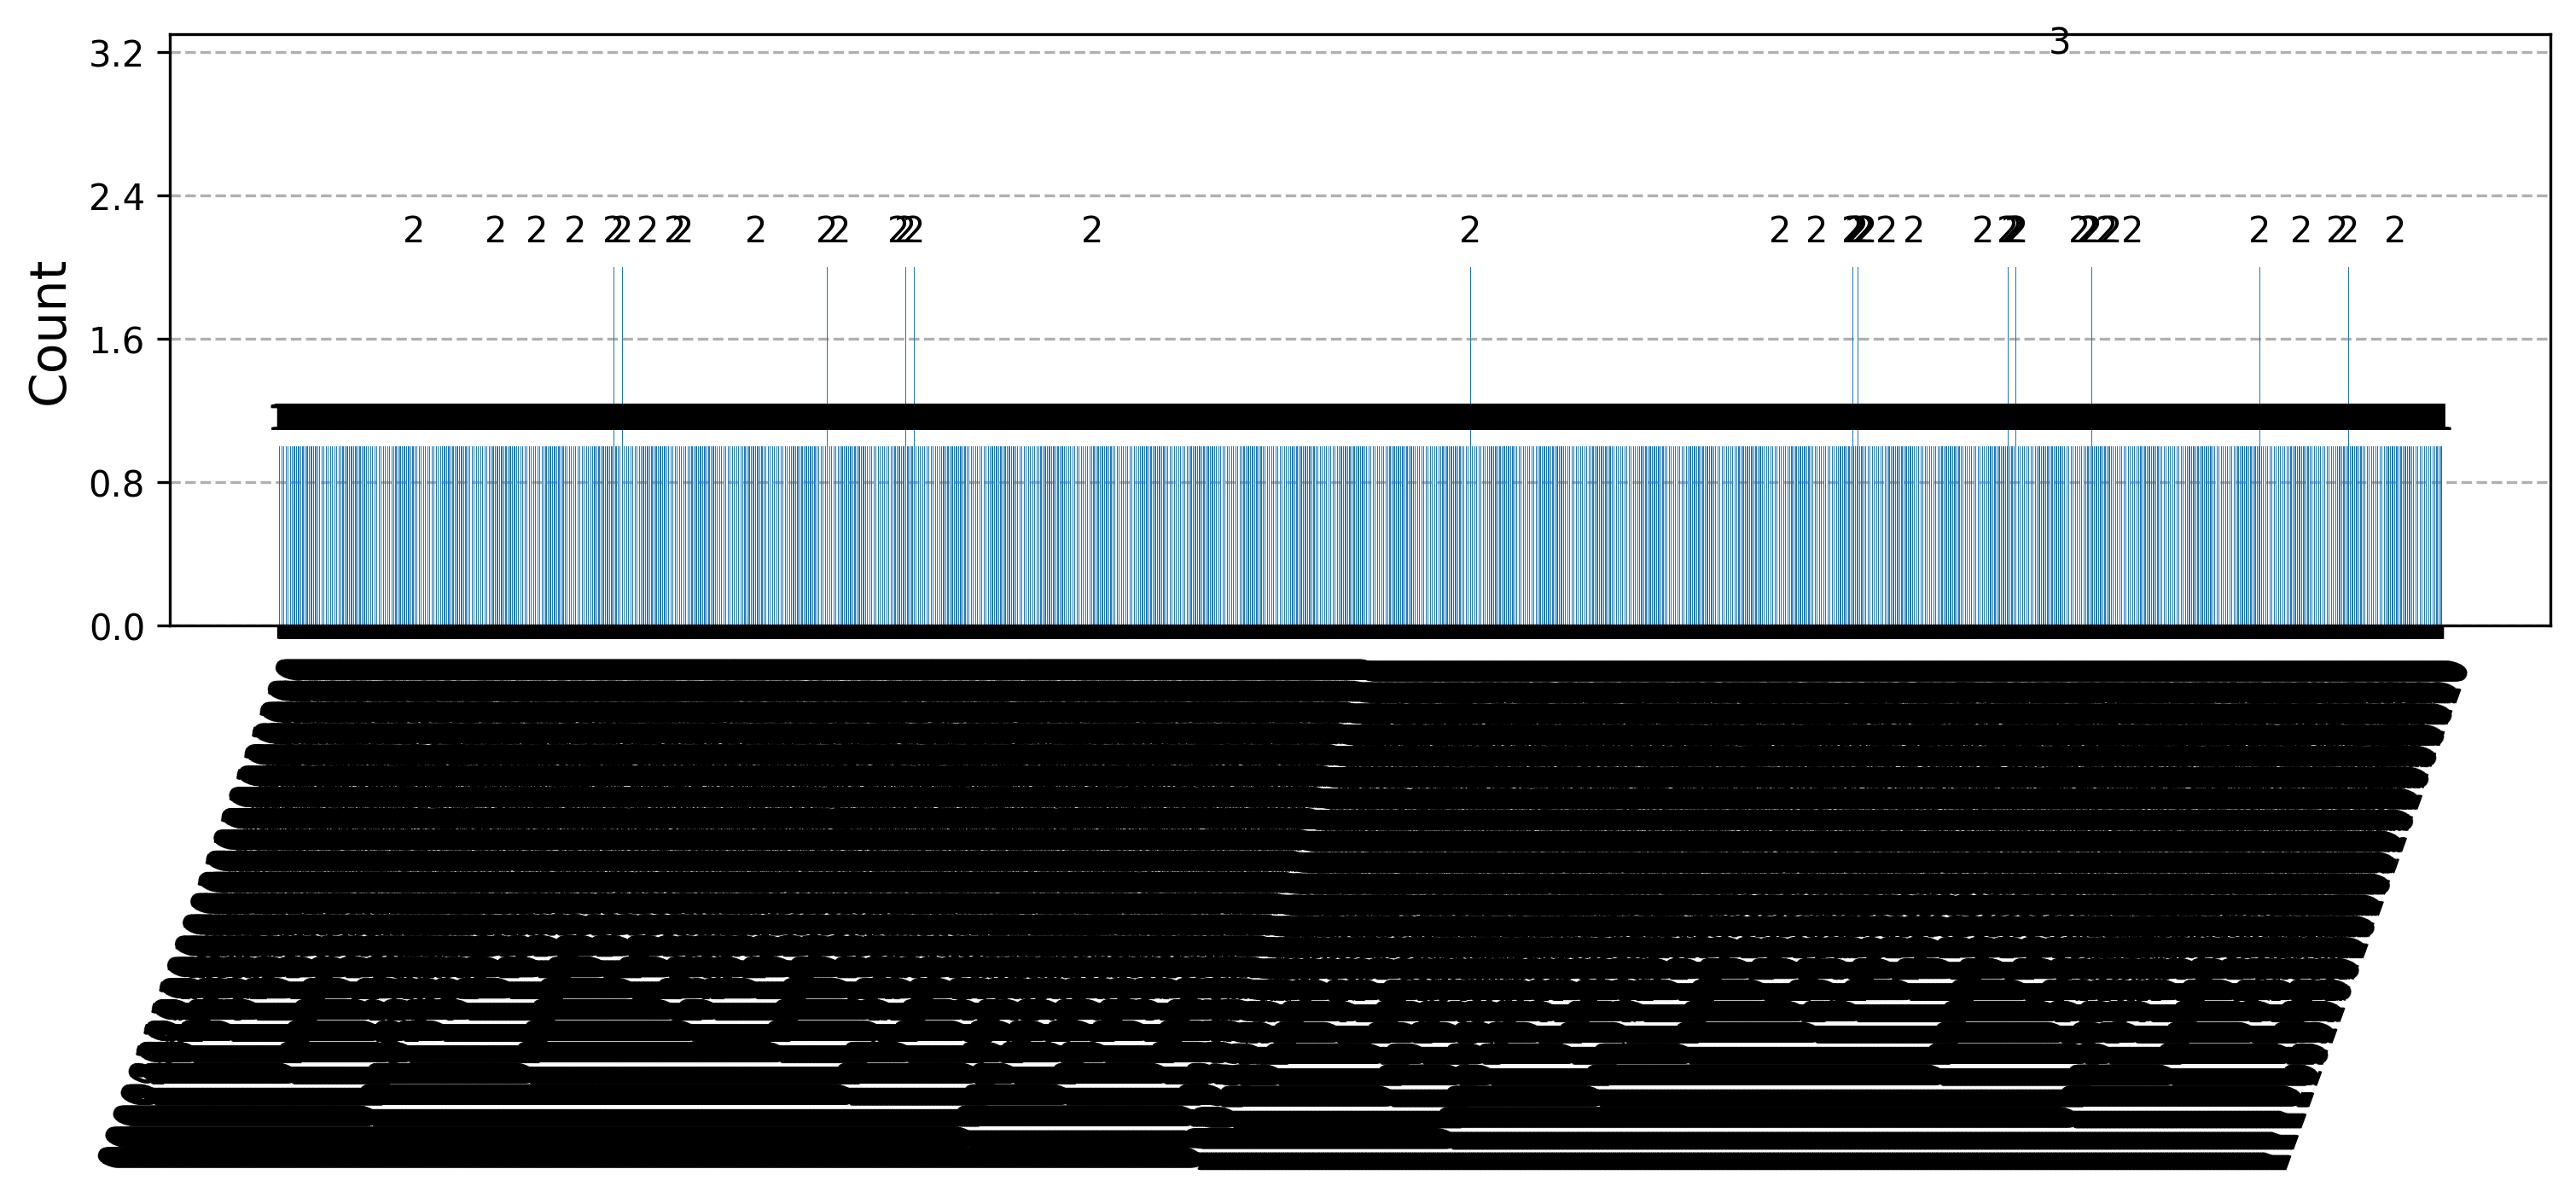

In [7]:
counts = qft(wave.samples, 'basis', True)
print(f"Most frequent outcome: {max(counts, key=counts.get)}")
plot_histogram(counts)

      ┌───┐     ┌───────┐
 q_0: ┤ H ├─────┤0      ├
      ├───┤┌───┐│       │
 q_1: ┤ X ├┤ H ├┤1      ├
      ├───┤├───┤│       │
 q_2: ┤ X ├┤ H ├┤2      ├
      ├───┤├───┤│       │
 q_3: ┤ X ├┤ H ├┤3      ├
      ├───┤├───┤│       │
 q_4: ┤ X ├┤ H ├┤4      ├
      ├───┤└───┘│       │
 q_5: ┤ X ├─────┤5      ├
      ├───┤     │       │
 q_6: ┤ H ├─────┤6      ├
      └───┘     │       │
 q_7: ──────────┤7      ├
                │       │
 q_8: ──────────┤8      ├
                │       │
 q_9: ──────────┤9      ├
                │       │
q_10: ──────────┤10     ├
      ┌───┐     │       │
q_11: ┤ H ├─────┤11     ├
      ├───┤     │   QFT │
q_12: ┤ X ├─────┤12     ├
      ├───┤┌───┐│       │
q_13: ┤ X ├┤ H ├┤13     ├
      ├───┤├───┤│       │
q_14: ┤ X ├┤ H ├┤14     ├
      ├───┤├───┤│       │
q_15: ┤ X ├┤ H ├┤15     ├
      ├───┤├───┤│       │
q_16: ┤ X ├┤ H ├┤16     ├
      ├───┤└───┘│       │
q_17: ┤ X ├─────┤17     ├
      ├───┤     │       │
q_18: ┤ H ├─────┤18     ├
      └───┘ 

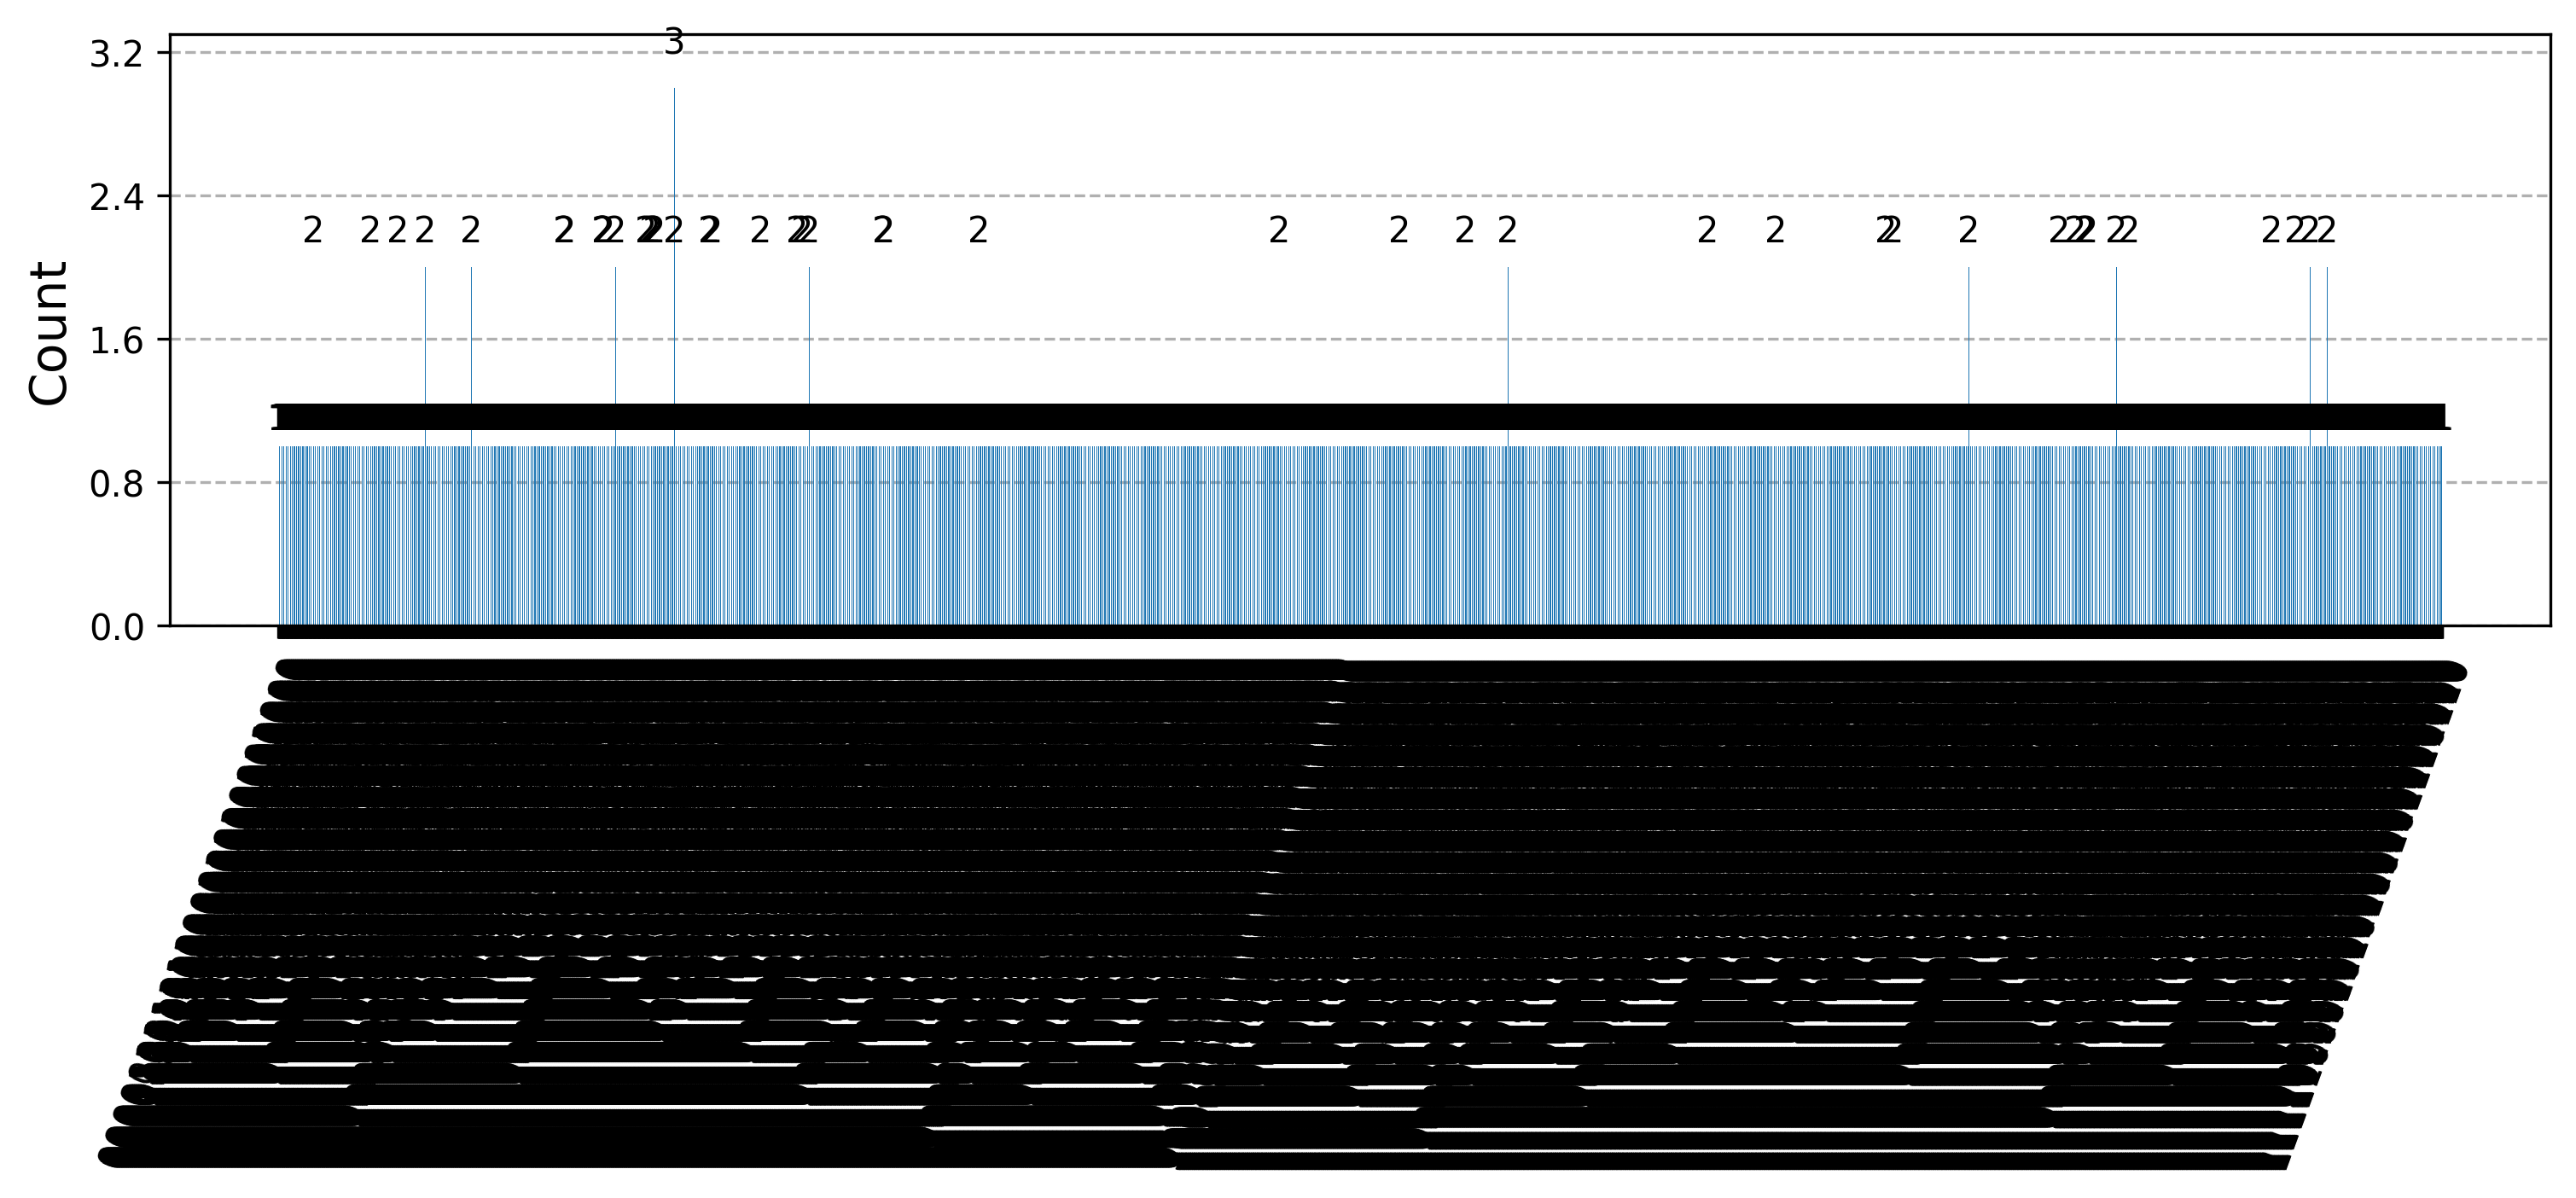

In [8]:
counts = qft(wave.samples, 'basis', False)
print(f"Most frequent outcome: {max(counts, key=counts.get)}")
plot_histogram(counts)

      ┌───┐    ┌──────┐   ┌───────────┐
 q_0: ┤ H ├────┤ P(0) ├───┤0          ├
      ├───┤ ┌──┴──────┴──┐│           │
 q_1: ┤ H ├─┤ P(0.51958) ├┤1          ├
      ├───┤ ├────────────┤│           │
 q_2: ┤ H ├─┤ P(0.88789) ├┤2          ├
      ├───┤ ├────────────┤│           │
 q_3: ┤ H ├─┤ P(0.99767) ├┤3          ├
      ├───┤ ├────────────┤│           │
 q_4: ┤ H ├─┤ P(0.81697) ├┤4          ├
      ├───┤ ├───────────┬┘│           │
 q_5: ┤ H ├─┤ P(0.3984) ├─┤5          ├
      ├───┤┌┴───────────┴┐│           │
 q_6: ┤ H ├┤ P(-0.13617) ├┤6          ├
      ├───┤├─────────────┤│           │
 q_7: ┤ H ├┤ P(-0.63109) ├┤7          ├
      ├───┤├─────────────┤│           │
 q_8: ┤ H ├┤ P(-0.94226) ├┤8          ├
      ├───┤├─────────────┤│           │
 q_9: ┤ H ├┤ P(-0.97908) ├┤9          ├
      ├───┤├─────────────┤│           │
q_10: ┤ H ├┤ P(-0.73084) ├┤10         ├
      ├───┤└┬────────────┤│           │
q_11: ┤ H ├─┤ P(-0.2698) ├┤11         ├
      ├───┤ ├───────────┬┘│   IQFT_dg │


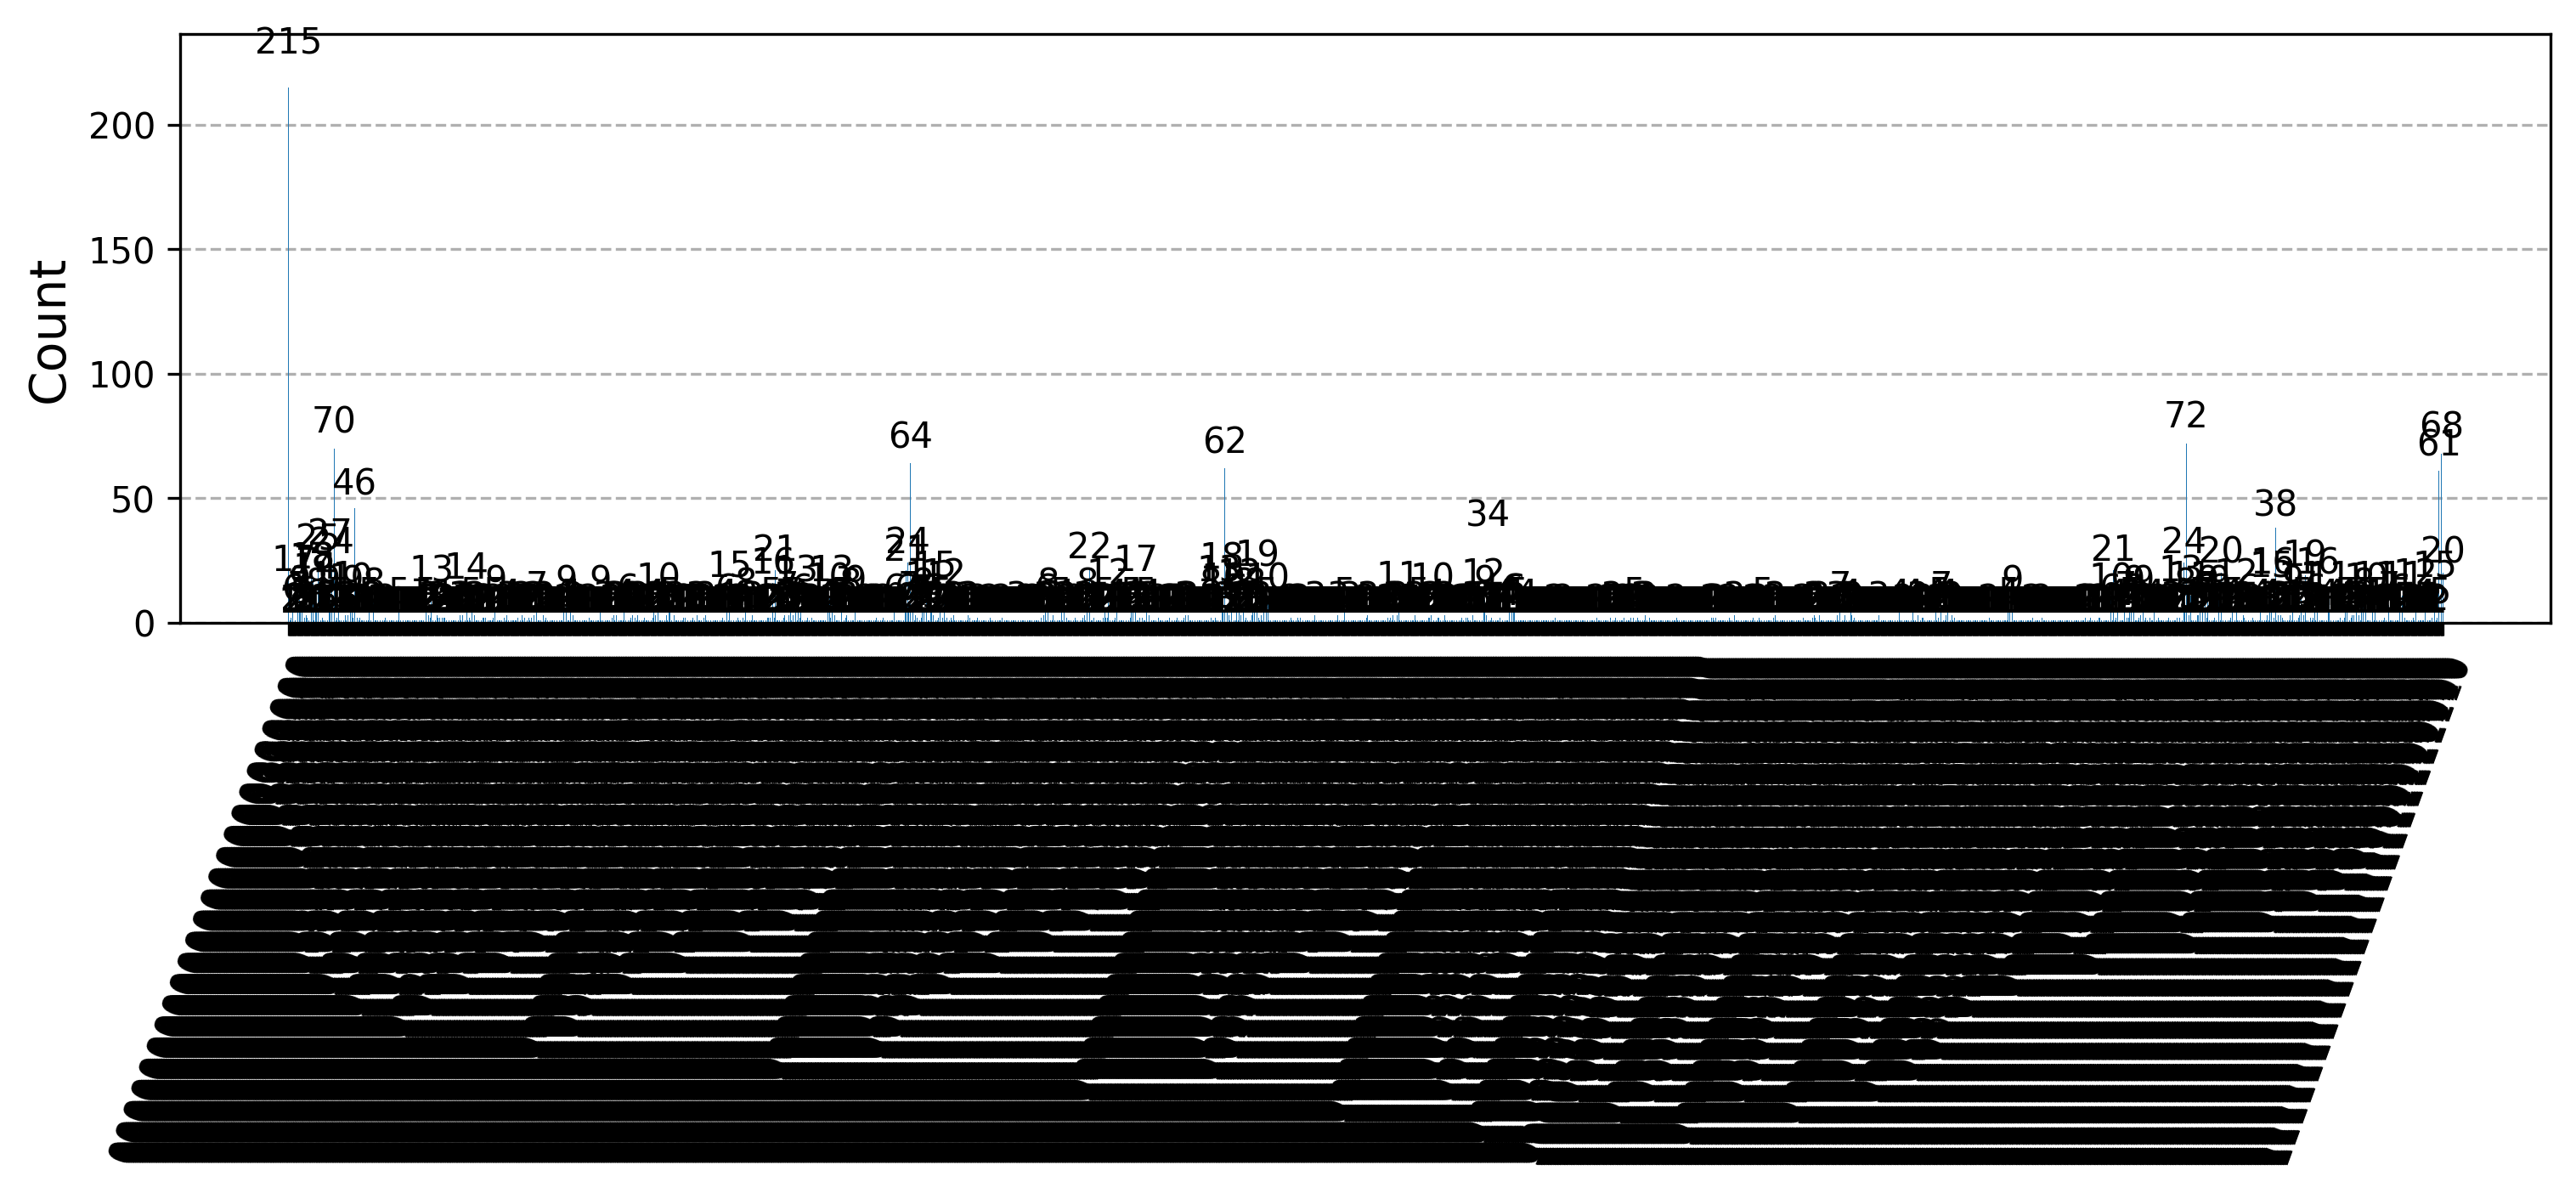

In [9]:
counts = qft(wave.samples, 'phase', True)
print(f"Most frequent outcome: {max(counts, key=counts.get)}")
plot_histogram(counts)

      ┌───┐    ┌──────┐   ┌───────┐
 q_0: ┤ H ├────┤ P(0) ├───┤0      ├
      ├───┤ ┌──┴──────┴──┐│       │
 q_1: ┤ H ├─┤ P(0.51958) ├┤1      ├
      ├───┤ ├────────────┤│       │
 q_2: ┤ H ├─┤ P(0.88789) ├┤2      ├
      ├───┤ ├────────────┤│       │
 q_3: ┤ H ├─┤ P(0.99767) ├┤3      ├
      ├───┤ ├────────────┤│       │
 q_4: ┤ H ├─┤ P(0.81697) ├┤4      ├
      ├───┤ ├───────────┬┘│       │
 q_5: ┤ H ├─┤ P(0.3984) ├─┤5      ├
      ├───┤┌┴───────────┴┐│       │
 q_6: ┤ H ├┤ P(-0.13617) ├┤6      ├
      ├───┤├─────────────┤│       │
 q_7: ┤ H ├┤ P(-0.63109) ├┤7      ├
      ├───┤├─────────────┤│       │
 q_8: ┤ H ├┤ P(-0.94226) ├┤8      ├
      ├───┤├─────────────┤│       │
 q_9: ┤ H ├┤ P(-0.97908) ├┤9      ├
      ├───┤├─────────────┤│       │
q_10: ┤ H ├┤ P(-0.73084) ├┤10     ├
      ├───┤└┬────────────┤│       │
q_11: ┤ H ├─┤ P(-0.2698) ├┤11     ├
      ├───┤ ├───────────┬┘│   QFT │
q_12: ┤ H ├─┤ P(0.2698) ├─┤12     ├
      ├───┤ ├───────────┴┐│       │
q_13: ┤ H ├─┤ P(0.73084) ├┤1

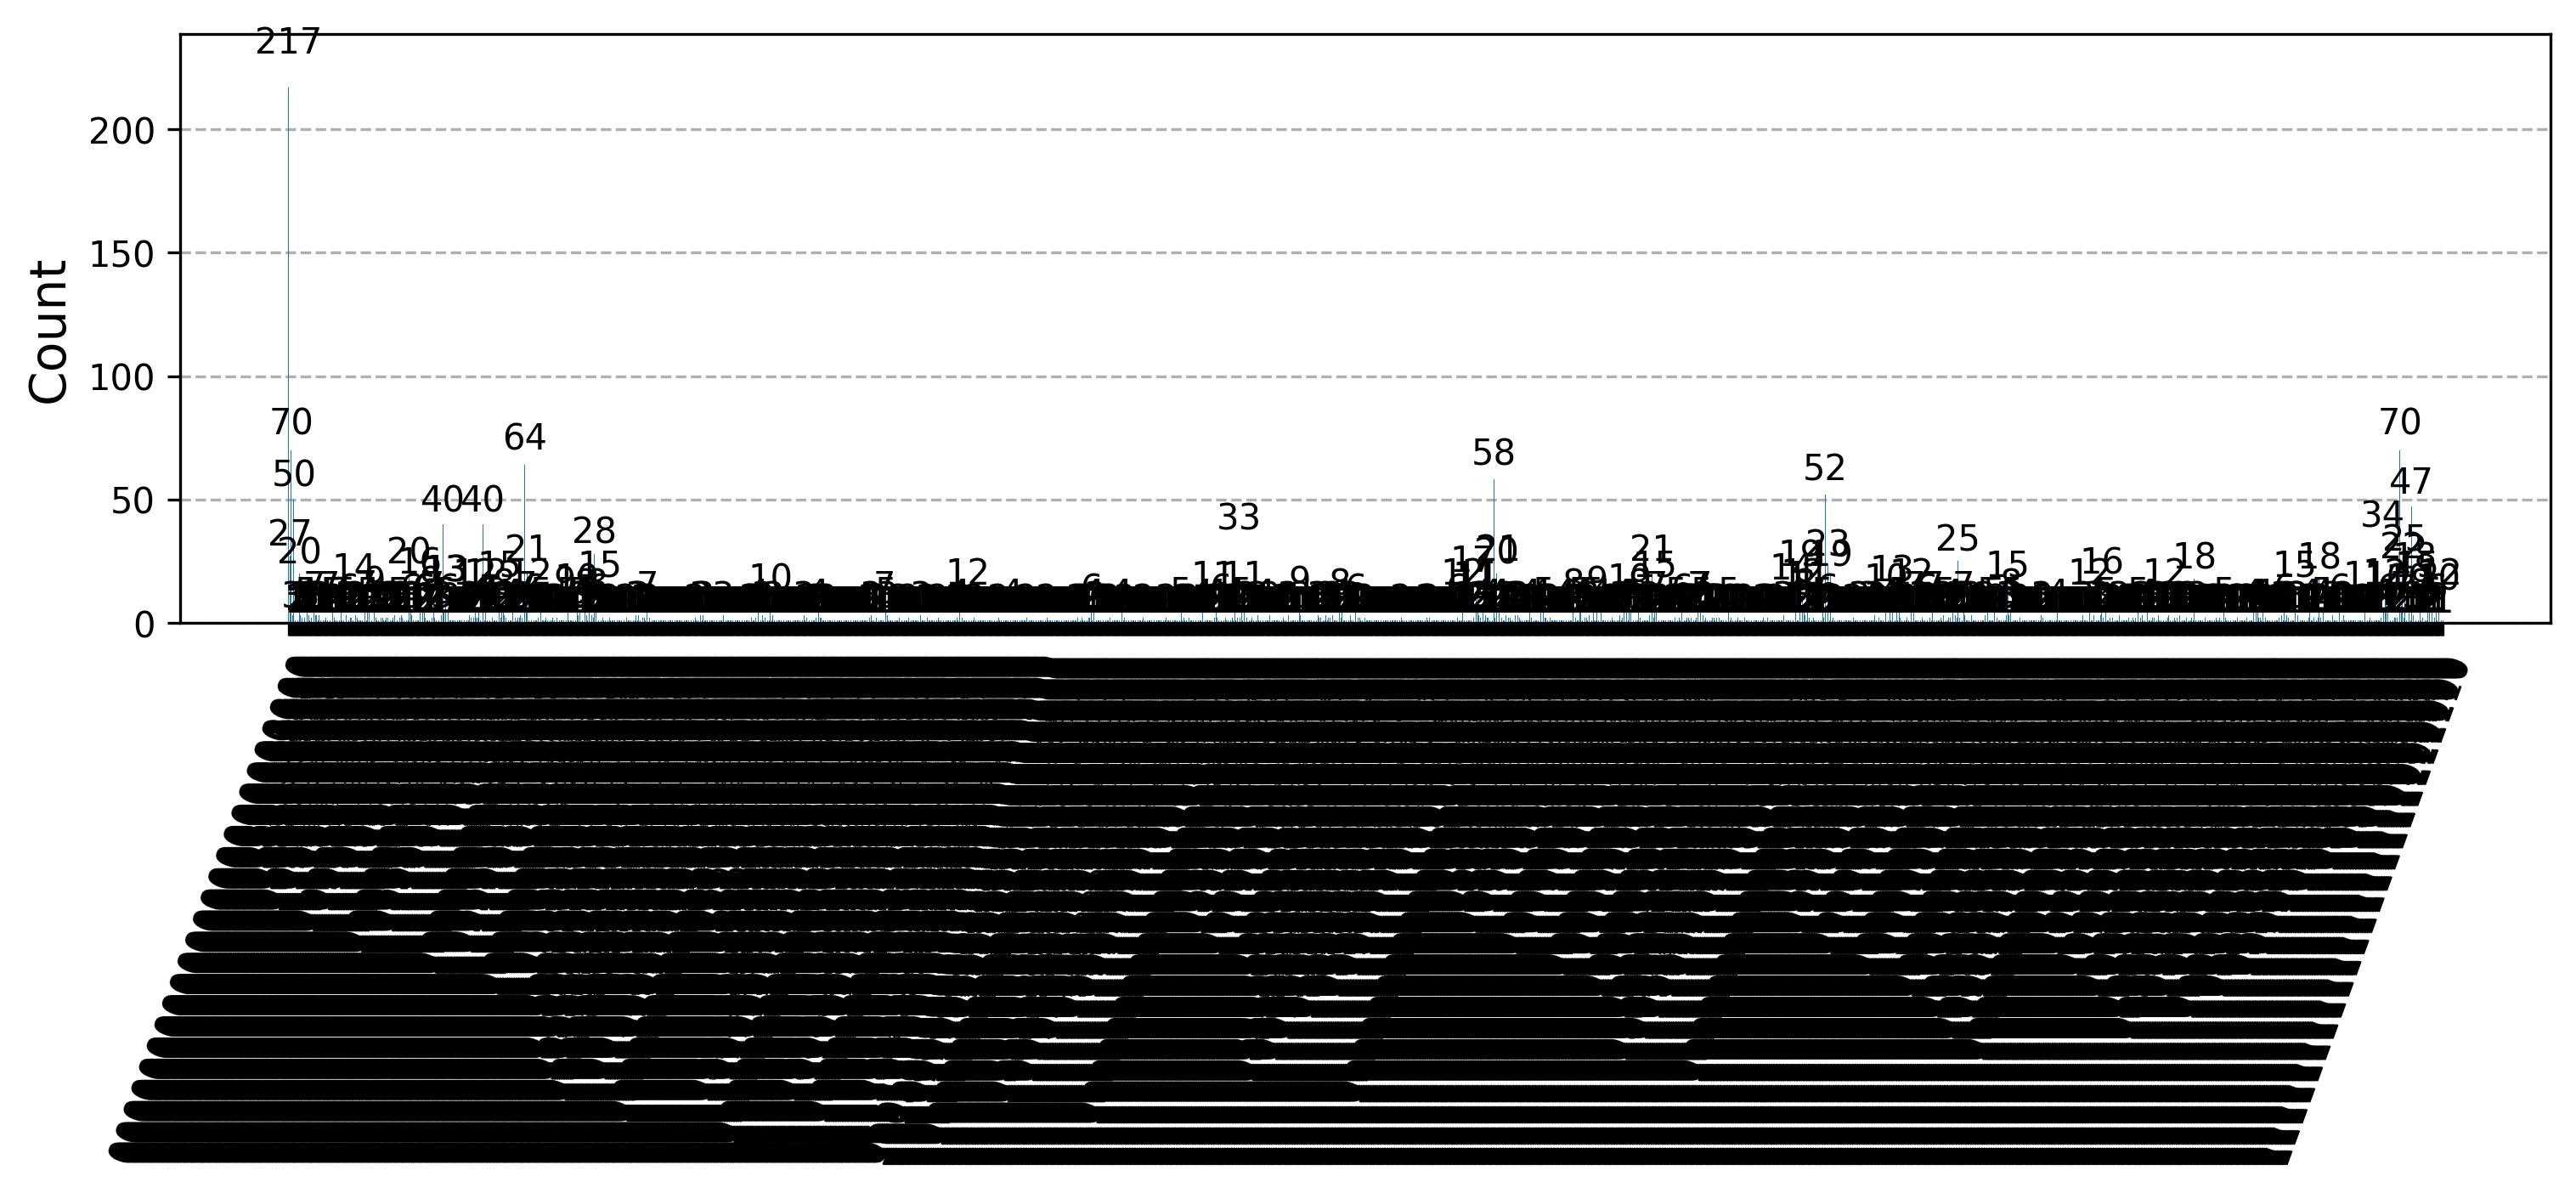

In [10]:
counts = qft(wave.samples, 'phase', False)
print(f"Most frequent outcome: {max(counts, key=counts.get)}")
plot_histogram(counts)

      ┌───┐   ┌───────┐    ┌───────────┐
 q_0: ┤ H ├───┤ Rz(0) ├────┤0          ├
      ├───┤┌──┴───────┴──┐ │           │
 q_1: ┤ H ├┤ Rz(0.51958) ├─┤1          ├
      ├───┤├─────────────┤ │           │
 q_2: ┤ H ├┤ Rz(0.88789) ├─┤2          ├
      ├───┤├─────────────┤ │           │
 q_3: ┤ H ├┤ Rz(0.99767) ├─┤3          ├
      ├───┤├─────────────┤ │           │
 q_4: ┤ H ├┤ Rz(0.81697) ├─┤4          ├
      ├───┤└┬────────────┤ │           │
 q_5: ┤ H ├─┤ Rz(0.3984) ├─┤5          ├
      ├───┤┌┴────────────┴┐│           │
 q_6: ┤ H ├┤ Rz(-0.13617) ├┤6          ├
      ├───┤├──────────────┤│           │
 q_7: ┤ H ├┤ Rz(-0.63109) ├┤7          ├
      ├───┤├──────────────┤│           │
 q_8: ┤ H ├┤ Rz(-0.94226) ├┤8          ├
      ├───┤├──────────────┤│           │
 q_9: ┤ H ├┤ Rz(-0.97908) ├┤9          ├
      ├───┤├──────────────┤│           │
q_10: ┤ H ├┤ Rz(-0.73084) ├┤10         ├
      ├───┤├─────────────┬┘│           │
q_11: ┤ H ├┤ Rz(-0.2698) ├─┤11         ├
      ├───┤└┬───

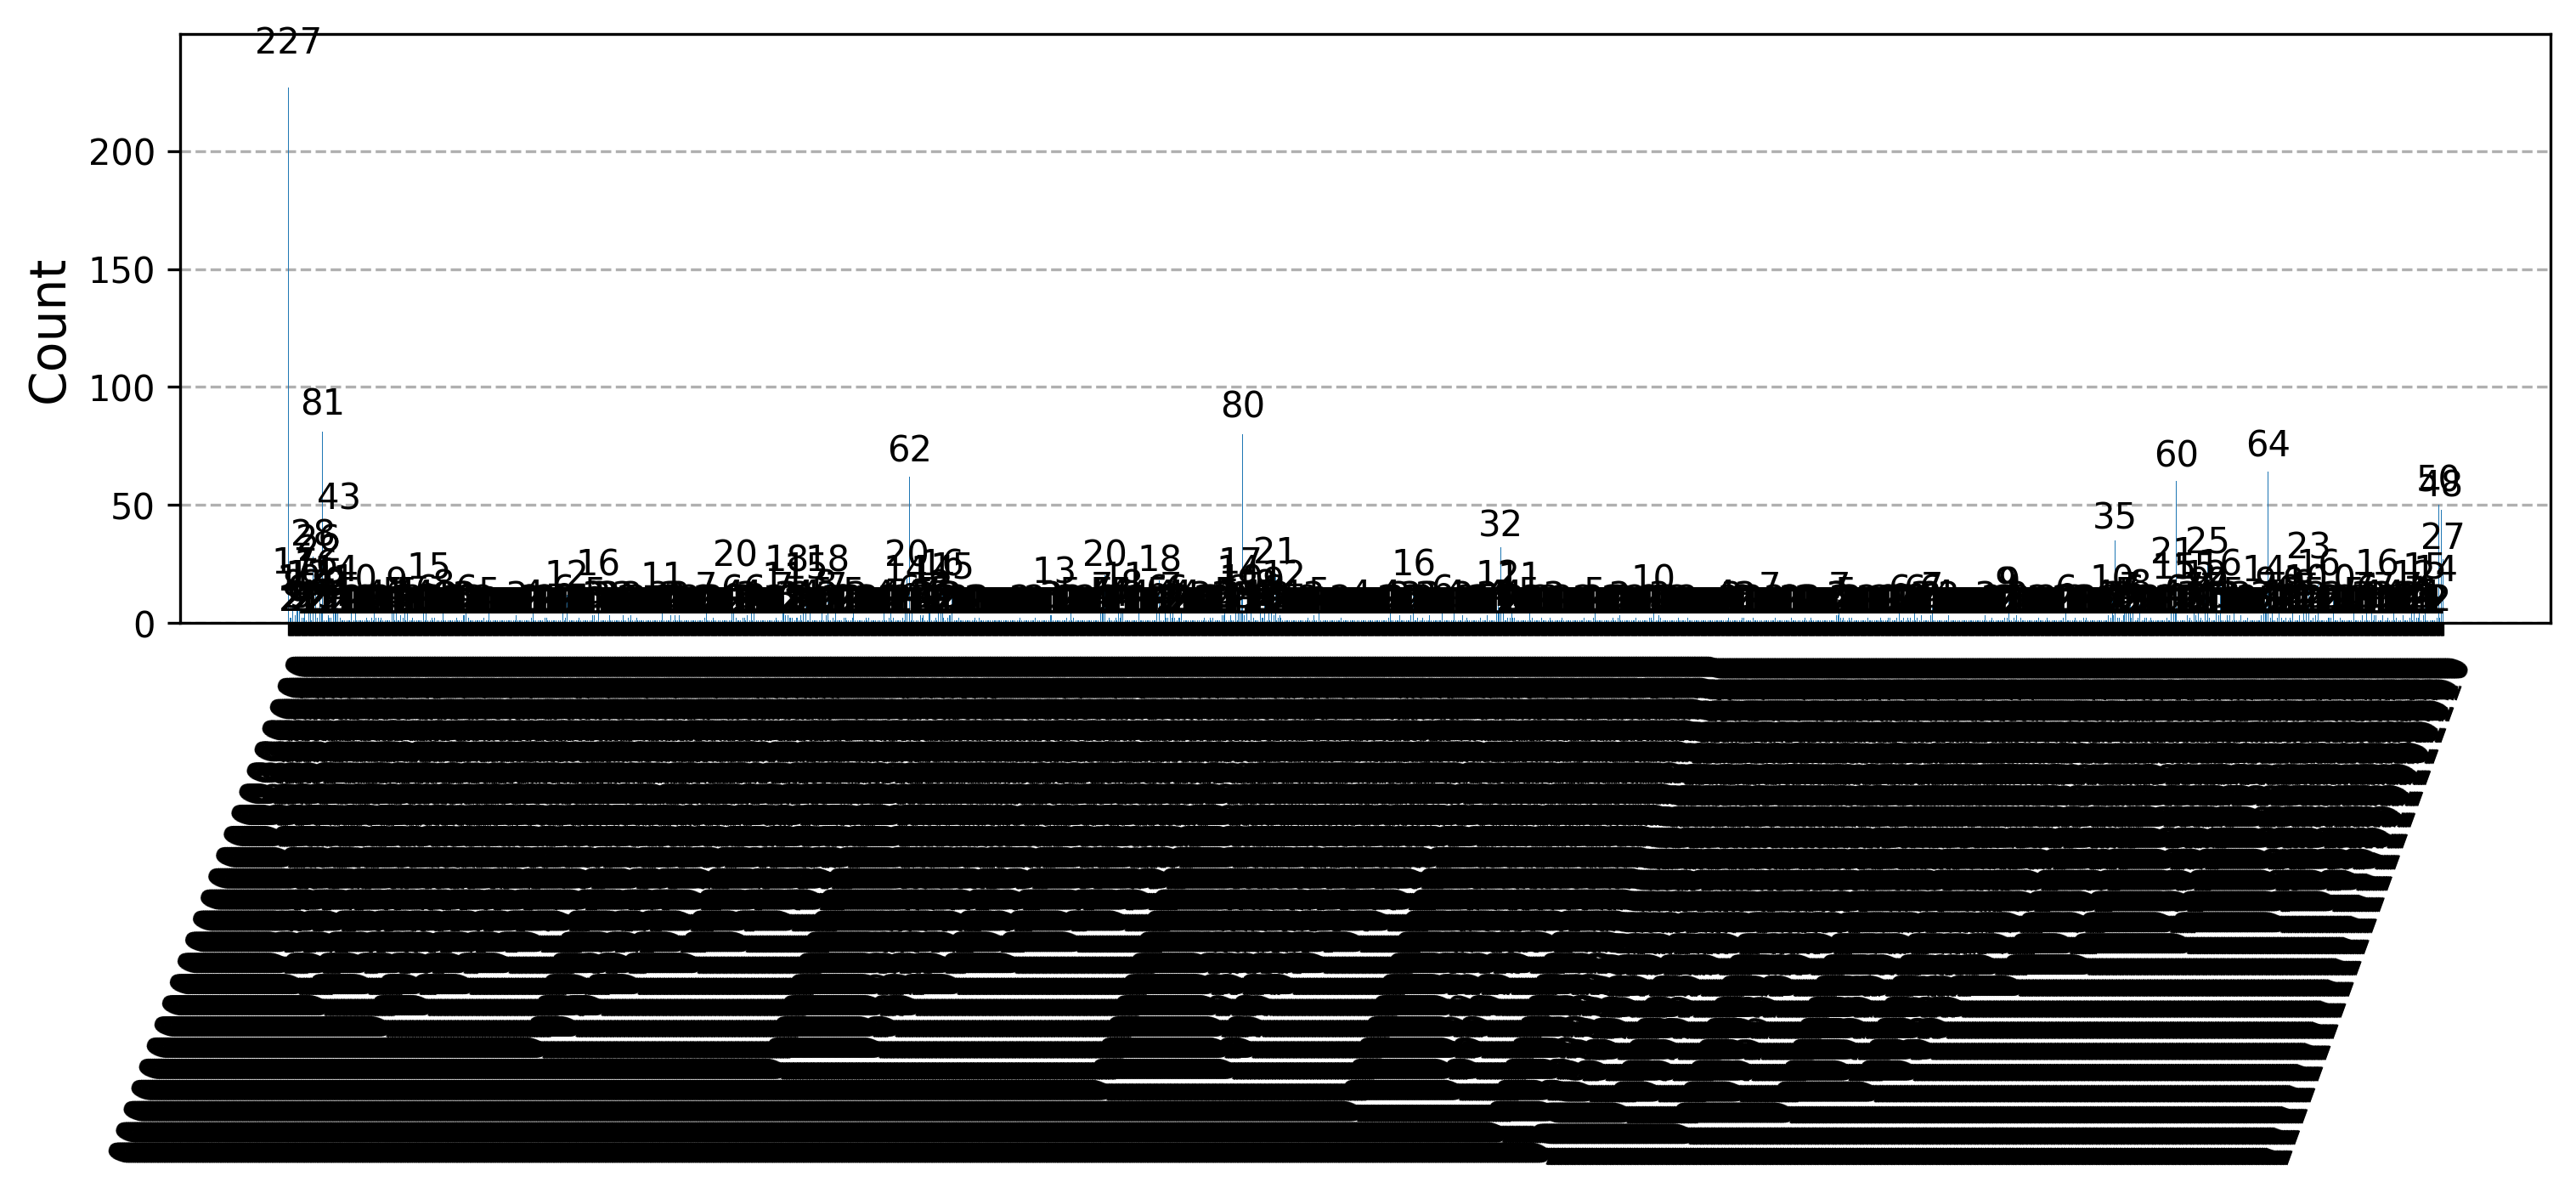

In [11]:
counts = qft(wave.samples, 'rz', True)
print(f"Most frequent outcome: {max(counts, key=counts.get)}")
plot_histogram(counts)

      ┌───┐   ┌───────┐    ┌───────┐
 q_0: ┤ H ├───┤ Rz(0) ├────┤0      ├
      ├───┤┌──┴───────┴──┐ │       │
 q_1: ┤ H ├┤ Rz(0.51958) ├─┤1      ├
      ├───┤├─────────────┤ │       │
 q_2: ┤ H ├┤ Rz(0.88789) ├─┤2      ├
      ├───┤├─────────────┤ │       │
 q_3: ┤ H ├┤ Rz(0.99767) ├─┤3      ├
      ├───┤├─────────────┤ │       │
 q_4: ┤ H ├┤ Rz(0.81697) ├─┤4      ├
      ├───┤└┬────────────┤ │       │
 q_5: ┤ H ├─┤ Rz(0.3984) ├─┤5      ├
      ├───┤┌┴────────────┴┐│       │
 q_6: ┤ H ├┤ Rz(-0.13617) ├┤6      ├
      ├───┤├──────────────┤│       │
 q_7: ┤ H ├┤ Rz(-0.63109) ├┤7      ├
      ├───┤├──────────────┤│       │
 q_8: ┤ H ├┤ Rz(-0.94226) ├┤8      ├
      ├───┤├──────────────┤│       │
 q_9: ┤ H ├┤ Rz(-0.97908) ├┤9      ├
      ├───┤├──────────────┤│       │
q_10: ┤ H ├┤ Rz(-0.73084) ├┤10     ├
      ├───┤├─────────────┬┘│       │
q_11: ┤ H ├┤ Rz(-0.2698) ├─┤11     ├
      ├───┤└┬────────────┤ │   QFT │
q_12: ┤ H ├─┤ Rz(0.2698) ├─┤12     ├
      ├───┤┌┴────────────┤ │       │
q

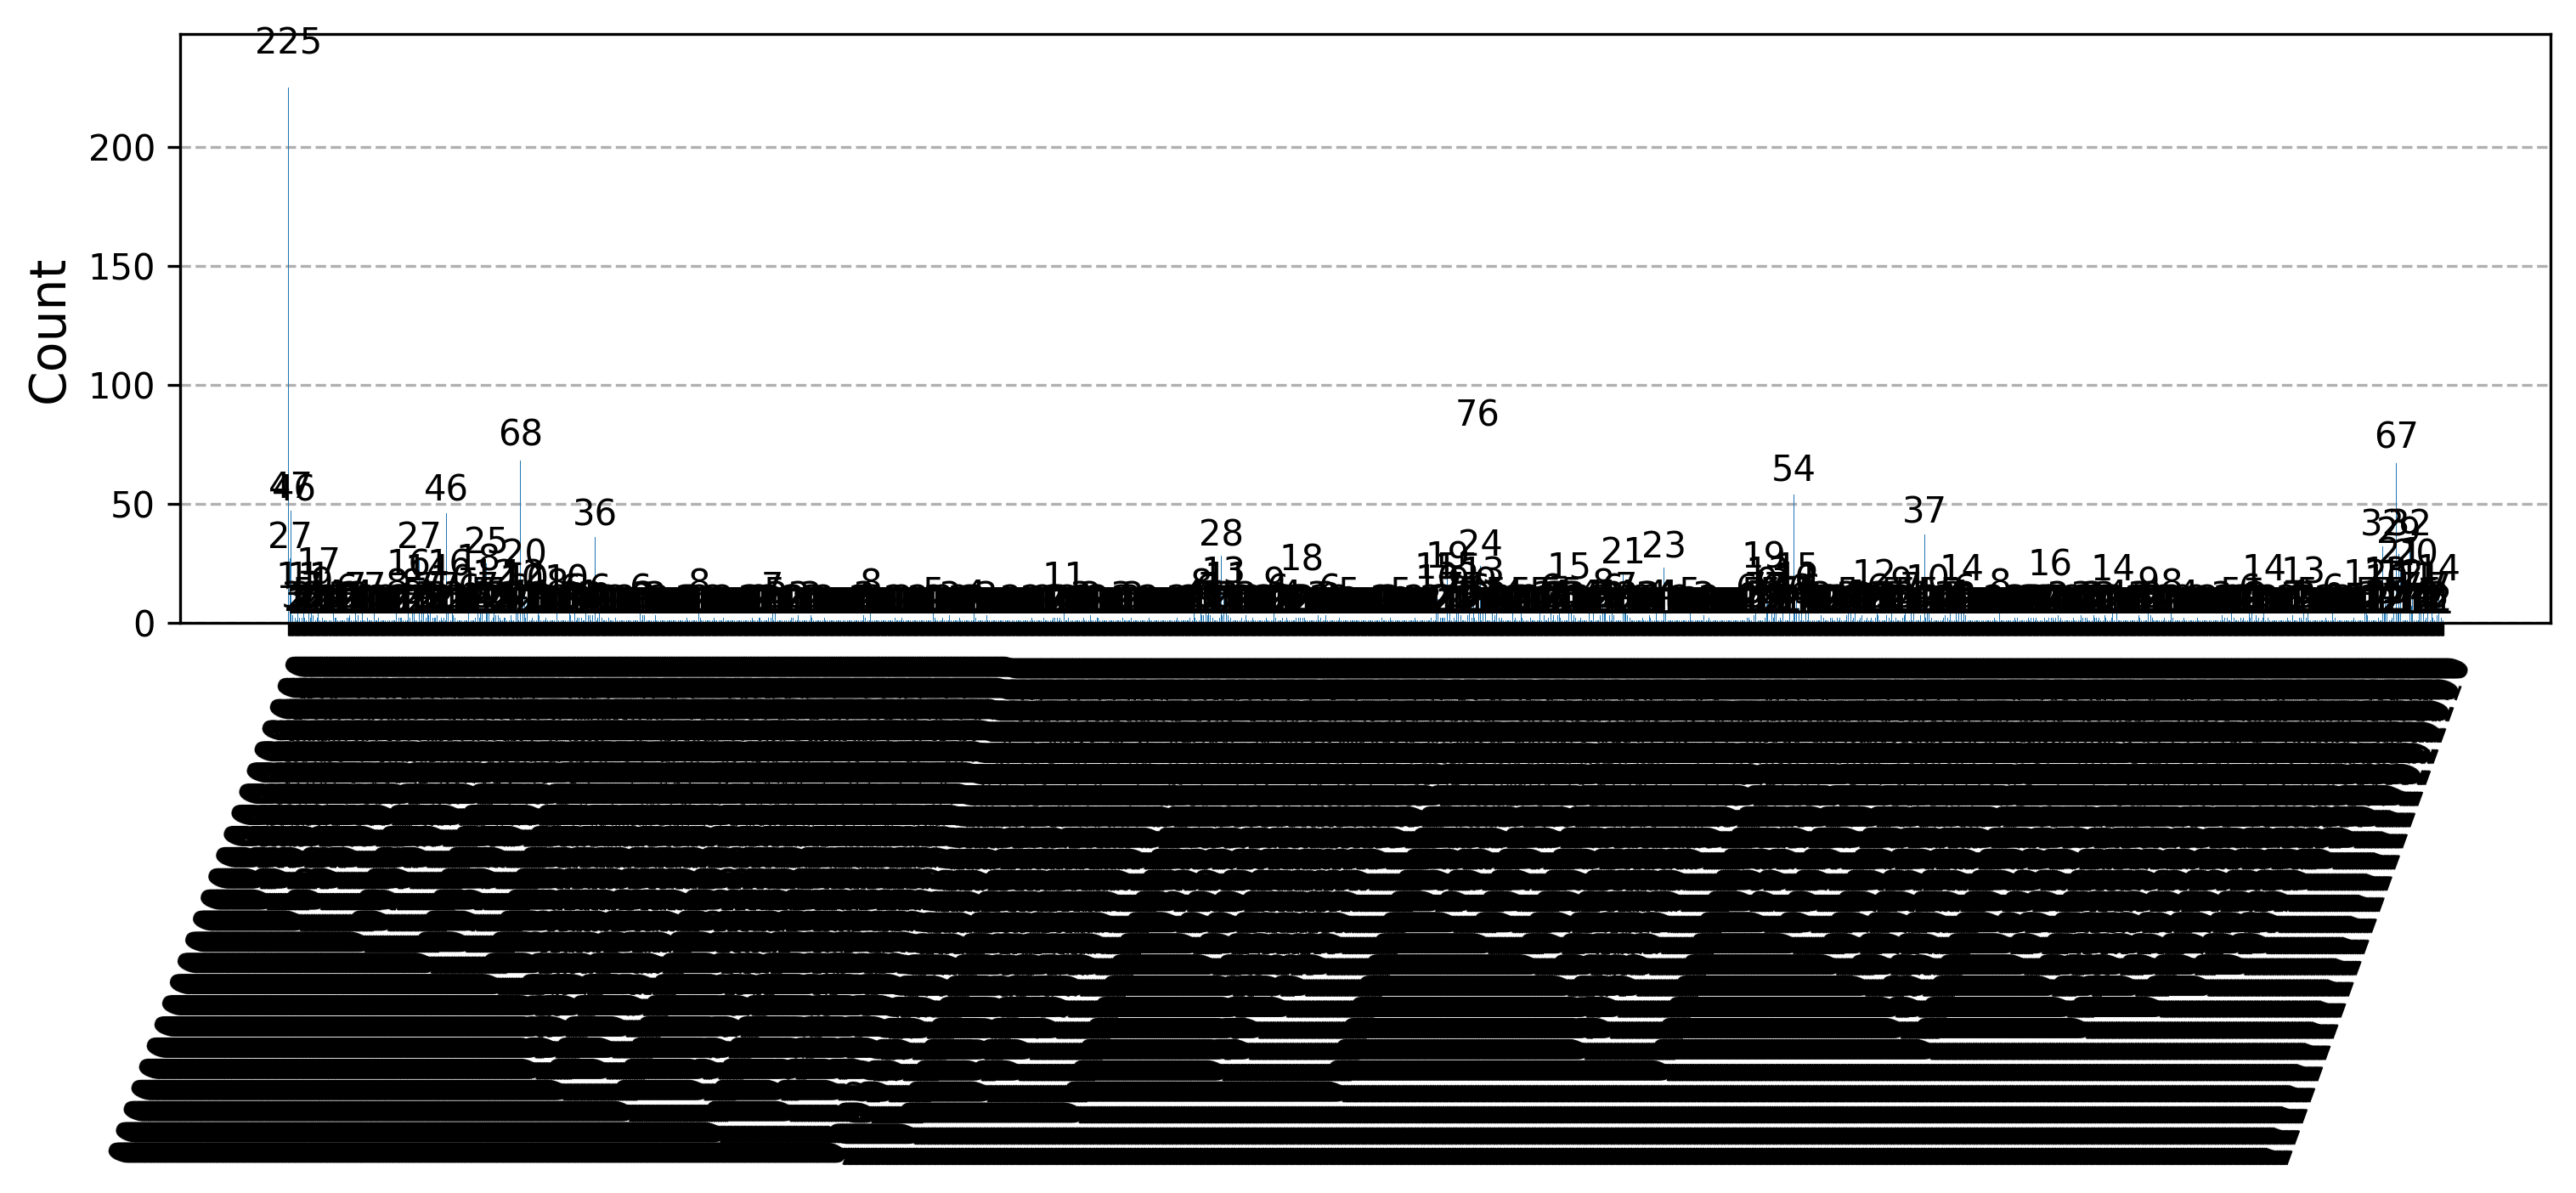

In [12]:
counts = qft(wave.samples, 'rz', False)
print(f"Most frequent outcome: {max(counts, key=counts.get)}")
plot_histogram(counts)